# Advanced Data Analysis 2023/24 - assignment 1

**NAME:** Martim Alves Ernesto Esteves

**NUMBER:** 46953

This notebook contains the **Assignment 1** of the Advanced Data Analysis course.

The topic of the assignment consists in performing multiple analysis on information about Olympic games. 


The data in the dataset provided was obtained from Kaggle.


### DEADLINE: 29-September-2023

The assignment is **individual**. You should submit your resolution on Moodle by the deadline. 

Students have **three grace days** that they can use for all assignments and group project, which allows them to deliver the projects late. Use these grace days carefully.

[//]: # (We will be using latex for fomulas)

<script type="text/javascript"
        src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.0/MathJax.js?config=TeX-AMS_CHTML"></script>


### Preliminaries

Just import the libraries that will be needed throughout the assignment.

In [1]:
# imports pandas
import pandas as pd

import os

import matplotlib.pyplot as plt

import seaborn as sns

!apt-get install openjdk-11-jdk-headless
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

## Datasets

For solving the questions posed, you have the following datasets available.

### Olympic Games Data

Data from the Olympic Games, for the period considered, were collected for each individual athlete in a given Olympic event (or race) and recorded in the file `athlete_events.csv`. For example, the following entry is for the first gold medal won by a Portuguese woman:

| |ID |Name |Sex |Age |Height |Weight |Team |NOC |Games |Year |Season |City |Sport |Event |Medal|
|---|---|-------|-------|-------|-------|-------|- ------|-------|-------|-------|-------|-------|--- ----|-----------|-----|
|164334 |82494 |Rosa Mara Correia dos Santos Mota |F |30 |157 |45 |Portugal |POR |1988 Summer |1988 |Summer |Seoul |Athletics |Athletics Women's Marathon |Gold|

The file structure is illustrated in the figure below:

![Olympic data](imgs/raw_athlete_events.png)

As can be seen, various information is recorded for each individual athlete in a given Olympic event, such as name (`Name`), gender (`Sex`), age (`Age`), edition of the Olympic Games (`Games `), the Olympic event (`Event`) among others. It should be noted that, for each athlete, there is an identifier (`ID`) that is unique to that athlete and invariable - it remains for all Olympic events in which that athlete has participated, regardless of the edition (year).

Regarding Olympic events, there are individual events and team events - e.g. football and the 4x100m relay are team events. In team events, the data includes one record for each athlete on the team.

### Population

CSV file `population.csv` includes information about the population of each country for a given year.

The csv file includes ISO3 code of the country (in lower case) (`geo`), the name of the country (`name`), the year (`time`) and the population (`population`).

### Country codes

CSV file `codes.csv` includes information about the different codes used for different countries.

The csv file includes, among other, the name of the country (`Country`), ISO3 code (`ISO3`) and the national olympic code (`IOC`).


The following code loads the datasets.


In [2]:
dataFileName = os.path.join( "data", "athlete_events.csv")
dataDF = pd.read_csv(dataFileName)

print(dataDF.head(5))

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

In [3]:
codesFileName = os.path.join( "data", "codes.csv")

codesDF = pd.read_csv(codesFileName)

print(codesDF.head(5))

          Country ISO2 ISO3   ISON  IOC FIPS Plates Domain
0     Afghanistan   AF  AFG    4.0  AFG   AF    AFG    .af
1   Åland Islands   AX  ALA  248.0  NaN  NaN     AX    .ax
2         Albania   AL  ALB    8.0  ALB   AL     AL    .al
3         Algeria   DZ  DZA   12.0  ALG   AG     DZ    .dz
4  American Samoa   AS  ASM   16.0  ASA   AQ    USA    .as


In [4]:
populationFileName = os.path.join( "data", "population.csv")

populationDF = pd.read_csv(populationFileName)

print(populationDF.head(5))

   geo         name  time  Population
0  afg  Afghanistan  1800   3280000.0
1  afg  Afghanistan  1801   3280000.0
2  afg  Afghanistan  1802   3280000.0
3  afg  Afghanistan  1803   3280000.0
4  afg  Afghanistan  1804   3280000.0


For data on atheletes, there are some information missing. We can compute the number of entries missing using the following code.

**NOTE:** the missing information on Medal is expected - it just means that the athlete has won no medal in the event.

In [5]:
dataDF.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

**GENERAL NOTE:** In your computations, if there are rows for which needed information is missing, just drop the rows.

**Additional Check:** In addition to checking missing values, also check if the data set has duplicated data rows. We then remove the duplicated rows from the dataset.

In [6]:
print('Rows:', dataDF.duplicated().any())

duplicates = dataDF[dataDF.duplicated()]
display(duplicates)
dataDF = dataDF.drop_duplicates()

Rows: True


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1252,704,Dsir Antoine Acket,M,27.0,NaN,NaN,Belgium,BEL,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN
4282,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",NaN
4283,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",NaN
4862,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Designs F...",NaN
4864,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Architect...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269994,135072,Anna Katrina Zinkeisen (-Heseltine),F,46.0,NaN,NaN,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Paintings",NaN
269995,135072,Anna Katrina Zinkeisen (-Heseltine),F,46.0,NaN,NaN,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Paintings",NaN
269997,135072,Anna Katrina Zinkeisen (-Heseltine),F,46.0,NaN,NaN,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN
269999,135073,Doris Clare Zinkeisen (-Johnstone),F,49.0,NaN,NaN,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN


In [7]:
# Remove Duplicates

dataDF = dataDF.drop_duplicates()

## Question 1 (7 points)

In this question, we start by exploring the data available with simple queries. In your answers, you can use the data computed in the previous answers if and when useful.


### **1.a)** How many athletes have participated in Summer Olympics and how many athlete participated in Winter Olympics?



In [42]:
df_unique_id_games = dataDF.drop_duplicates(['ID','Games'])
seasons_count = df_unique_id_games.groupby('Season').size()

display(seasons_count)

Season
Summer    158859
Winter     28593
dtype: int64

### **1.b)** Who are the three youngest and oldest athletes that won a Gold medal in the Olympic games?

Show the following information about each athelete: Name, Age, Team, Games, Sport and Event.


In [12]:
df_ages_gold_sorted = dataDF[dataDF['Medal']=='Gold'].dropna(subset='Age').sort_values('Age')       

athletes_young = df_ages_gold_sorted.nsmallest(3, 'Age')[['Name','Age', 'Games', 'Sport', 'Event']]
athletes_old = df_ages_gold_sorted.nlargest(3, 'Age')[['Name','Age', 'Games', 'Sport', 'Event']]

# output formatting
athletes_young.index.name, athletes_old.index.name = 'ID', 'ID'
display(athletes_young)
display(athletes_old)

,Name,Age,Games,Sport,Event
ID,,,,,
27207,Hans Bourquin,13.0,1928 Summer,Rowing,Rowing Men's Coxed Pairs
52010,Donna Elizabeth de Varona (-Pinto),13.0,1960 Summer,Swimming,Swimming Women's 4 x 100 metres Freestyle Relay
200704,Aileen Muriel Riggin (-Soule),13.0,1920 Summer,Diving,Diving Women's Springboard


,Name,Age,Games,Sport,Event
ID,,,,,
105199,Charles Jacobus,64.0,1904 Summer,Roque,Roque Men's Singles
233390,Oscar Gomer Swahn,64.0,1912 Summer,Shooting,"Shooting Men's Running Target, Single Shot, Team"
104003,Isaac Lazarus Israls,63.0,1928 Summer,Art Competitions,"Art Competitions Mixed Painting, Paintings"


### Comments
In the case where the three youngest or oldest athletes are tied, ties will be broken by which athletes appear first in the dataset (so consequently by id number).

### 1.c) Who are the top-10 athletes that have won more Gold medals in the Olympic Games?



In [10]:
df_gold_count = dataDF[dataDF['Medal']=='Gold'].groupby('ID').size()   

gold_top_10 = df_gold_count.sort_values(ascending=False).nlargest(10).to_frame('Gold Count').reset_index()

gold_top_10 = gold_top_10.join(dataDF[['ID','Name']].drop_duplicates().set_index('ID'), on='ID')        # .drop_duplicates because athletes have multiple entries in dataDF

# output formatting
gold_top_10.index = range(1,11)
gold_top_10.index.name = 'Rank'
display(gold_top_10)


,ID,Gold Count,Name
Rank,,,
1,94406,23,"Michael Fred Phelps, II"
2,33557,10,"Raymond Clarence ""Ray"" Ewry"
3,113912,9,Mark Andrew Spitz
4,69210,9,"Frederick Carlton ""Carl"" Lewis"
5,87390,9,Paavo Johannes Nurmi
6,67046,9,Larysa Semenivna Latynina (Diriy-)
7,11642,8,"Matthew Nicholas ""Matt"" Biondi"
8,11951,8,Ole Einar Bjrndalen
9,57998,8,Sawao Kato


### Comments

As in question b), whenever there is a tie in the count of gold medals, the athlete that appears first in the data set has priority. The question asks to identify the top 10 gold medalists, and to do so we only use the name. We cannot include other information like the country and age since these evolve over time. Also, some athletes participated in different Sports and, within each sport, different Events throughout their careers. For this reason, we include only the name, id and number of gold medals in the output.

We can check if there are any athletes where their information changes with the following code:

```Python 
(dataDF.groupby('ID')[Column_Name].nunique()>1).any()
```
If the output is True, then there is at least one athlete where that variable changes.

### 1.d) For Summer Olympics, after 1950, who are the athletes that have won more medals in each edition?

Show the following information: Year, Name of athlete, and number of medals.

In [11]:
df_summer = dataDF[(dataDF['Year']>1950) & (dataDF['Season']=='Summer') & (~(dataDF['Medal'].isna()))]

df_medal_count_year = df_summer.groupby(['Year', 'ID']).size()

df_medal_max_index = df_medal_count_year.groupby('Year').idxmax() # get the index of the max value for each year, then filter the datafrmae by that index

df_medal_count_year = df_medal_count_year.loc[df_medal_max_index].to_frame('Number of Medals').join(df_summer[['ID', 'Name', 'Year']].drop_duplicates().set_index(['Year', 'ID']), on=['Year', 'ID'])

display(df_medal_count_year)

,,Number of Medals,Name
Year,ID,,
1952,50011,7,Mariya Kindrativna Horokhovska
1956,58489,6,gnes Keleti-Srkny (Klein)
1960,109161,7,Borys Anfiyanovych Shakhlin
1964,67046,6,Larysa Semenivna Latynina (Diriy-)
1968,127501,7,Mikhail Yakovlevich Voronin
1972,113912,7,Mark Andrew Spitz
1976,4198,7,Nikolay Yefimovich Andrianov
1980,28790,8,Aleksandr Nikolayevich Dityatin
1984,69459,6,Li Ning


### Comments
In case of ties, the athlete that appears first is selected.

### 1.e) For each athlete, compute the number of gold, silver and bronze medals she/he has won.

**Suggestions:** two alternative suggestion are investigating pivot tables and custom defined aggregation functions.


In [13]:
df_medal_count_id = dataDF[~(dataDF['Medal'].isna())].pivot_table(index=['ID', 'Name'], columns='Medal', values='Sex', aggfunc='count', fill_value=0).sort_values(['Gold', 'Silver', 'Bronze'], ascending=False)
# aggfunc = 'count' will count the values (in any column that is not the pivot index) for each ID and medal combination

df_medal_count_id = df_medal_count_id[['Gold', 'Silver', 'Bronze']]
display(df_medal_count_id)

,Medal,Gold,Silver,Bronze
ID,Name,,,
94406,"Michael Fred Phelps, II",23,3,2
33557,"Raymond Clarence ""Ray"" Ewry",10,0,0
67046,Larysa Semenivna Latynina (Diriy-),9,5,4
87390,Paavo Johannes Nurmi,9,3,0
113912,Mark Andrew Spitz,9,1,1
...,...,...,...,...
135504,Viktor Oleksandrovych Zviahintsev,0,0,1
135508,Vera Igorevna Zvonaryova,0,0,1
135525,Martin Zwicker,0,0,1


### 1.f) For the games of 2016, print the table of medals for each country.

**NOTE:** for collective events (e.g. football, 4*100 meters), you should count only one medal for a given event.
In the cell after the code, explain the rationale of the code to achieve this goal - your solution does not need to be perfect, but only an approximation of the real value.


In [18]:
df_medal_count_country = dataDF.dropna(subset='Medal').drop_duplicates(subset=['Year', 'Team', 'Event', 'Medal']).groupby(['Year', 'NOC', 'Season']).size().sort_index()  # group by season for a later question
df_medal_count_country_2016 = df_medal_count_country.loc[(2016)].sort_values(ascending=False).droplevel('Season')

display(df_medal_count_country_2016)

NOC
USA    121
CHN     70
GBR     67
RUS     56
FRA     42
      ... 
QAT      1
PUR      1
POR      1
NGR      1
JOR      1
Length: 86, dtype: int64

**Rationale:**
In order to avoid counting team sports' medals multiple times, we can use drop_duplicates to select only one athlete when multiple athletes from the same team win the same medal at same event. So in team events, we would only select one row and consequently only count one medal for the country. In the drop_duplicates(), we subset for 'Team' instead of 'NOC' because if two athletes from the same country but different teams tie for a medal, we should count as two medals, since the two teams are competing against each other.

However, it is possible for multiple athletes from the same country to tie for the same medal in individual sports. Most likely, they are also classified in the Dataset as having the same team, so our method would overlook the fact that it is an individual sport and count only one medal. Take for example the Sydney 2000 Olympics, where two American athletes tied for gold in Men's 50 meter freestyle.This is however a very rare occurance, and does not happen once in the 2016 Olympics.

## Question 2 (2 points)

It is normal that smaller countries conquer less medals, as their population is smaller.
In this question, we try to put the number of medals into prespective, considering the population of countries.




### 2.a) For the games of 2016, print the table of medals for each country per million inhabitants.



In [46]:
# Join Population with Country Codes
df_population_codes = populationDF[populationDF['time']==2016].rename(columns={'geo':'ISO3'})
df_population_codes['ISO3'] = df_population_codes['ISO3'].str.upper()
df_population_codes = df_population_codes.join(codesDF.set_index('ISO3')['IOC'], on='ISO3').sort_values('IOC')

# Join Medal Count with Population and Compute Medals per Million
df_medal_count_country_million_2016 = df_medal_count_country_2016.to_frame('Medal Count').reset_index().rename(columns={'NOC':'IOC'}).join(df_population_codes.set_index('IOC')[['Population', 'name']], on='IOC', how='inner')
df_medal_count_country_million_2016['Medal Count per Million'] = df_medal_count_country_million_2016['Medal Count']/(df_medal_count_country_million_2016['Population']/1000000)

df_medal_count_country_million_2016 = df_medal_count_country_million_2016.set_index('IOC')[['name','Medal Count per Million']].sort_values('Medal Count per Million', ascending=False)
display(df_medal_count_country_million_2016)

,name,Medal Count per Million
IOC,,
GRN,Grenada,8.335695
BAH,Bahamas,5.050811
JAM,Jamaica,3.924794
NZL,New Zealand,3.855974
DEN,Denmark,2.628417
...,...,...
VIE,Vietnam,0.021476
INA,Indonesia,0.011457
PHI,Philippines,0.009535


### Comment
We need to match the population data with the medals data. However, the medals data identifies countries with IOC codes (NOC column), while the population data identifies countries with ISO3 codes (geo column). The code above uses joins operations to make the match, using the codes.csv file to match the IOC and ISO3 codes.
There is an additional mismatch between the populations data and medals data, as some countries don't have population recorded but still have an entry in the population dataset, as well as olympic mealds (e.g. Kosovo). For that case we use inner join.

## Question 3 (4 points)

This third question focus on processing the information on a time series for plotting it.


### 3.a) Display the information about the number of athletes and medals wons by a country in the Olympic games over the years.

Select a country that has a significative number of medals and plot the results.
Discuss the rationale of your solution, including why you have decided to show the lines you are presenting and any processing you have done to the lines.


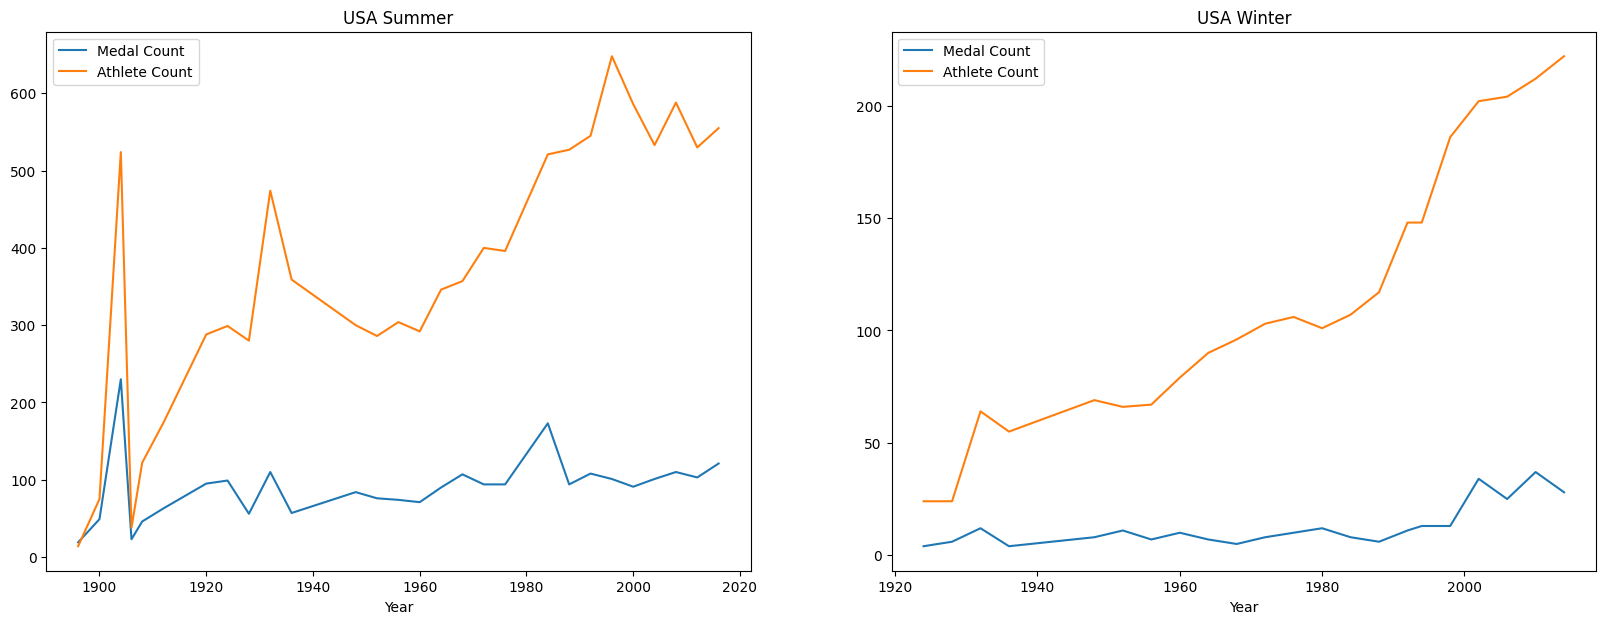

In [24]:
df_athletes_count = dataDF.drop_duplicates(['ID','Year']).groupby(['Year', 'NOC', 'Season']).size()

df_athletes_medal_count_summer = pd.DataFrame({'Medal Count': df_medal_count_country.loc[(__builtins__.slice(None), __builtins__.slice(None), 'Summer')], 'Athlete Count': df_athletes_count.loc[(__builtins__.slice(None), __builtins__.slice(None), 'Summer')]})
df_athletes_medal_count_summer = df_athletes_medal_count_summer.fillna(0).astype(int).sort_values(['Year','Medal Count'], ascending = [True, False])

df_athletes_medal_count_winter = pd.DataFrame({'Medal Count': df_medal_count_country.loc[(__builtins__.slice(None), __builtins__.slice(None), 'Winter')], 'Athlete Count': df_athletes_count.loc[(__builtins__.slice(None), __builtins__.slice(None), 'Winter')]})
df_athletes_medal_count_winter = df_athletes_medal_count_winter.fillna(0).astype(int).sort_values(['Year','Medal Count'], ascending = [True, False])

df_athletes_medal_count_summer_usa = df_athletes_medal_count_summer.loc[(__builtins__.slice(None), ['USA']),:].droplevel('NOC')
df_athletes_medal_count_winter_usa = df_athletes_medal_count_winter.loc[(__builtins__.slice(None), ['USA']),:].droplevel('NOC')


plt.figure(figsize=(20,7))
df_athletes_medal_count_summer_usa.plot(ax=plt.subplot(1,2,1), title='USA Summer')
df_athletes_medal_count_winter_usa.plot(ax=plt.subplot(1,2,2), title='USA Winter')
plt.show()


**Rationale:** 
Applying the same rationale as previous exercises, we use drop_duplicates to select only one athlete per year when there are multiple entries of the same athlete in the data set.

For this exercise we interpret "number of athletes over the years" as the number of distinct athletes that participated in each Year on the Olympics, by country. So, in cases where an athlete participates in multiple events/sports in the same year, he will only be counted once. We do this process for summer and winter olympics separately, since the number of athletes in each season is very different. This approach is better than doing both Olympics together, as this would result on the number of athletes and medals to go up and down as we go from summer to winter Olympics years and vice-versa.

After inspecting the data, we can select the USA to plot results due to their high number of medals. 

Note: We use __builtin__.slice(None) because pyspark also has this function, so in order to avoid conflicts we specifically import the function from the python builtins library.



### 3.b) Display trends of athletes and medals for a given country.

There might be some editions that are an outlier in the number of athletes or medals a given country wins. Instead of plotting the actual values, plot trend lines.



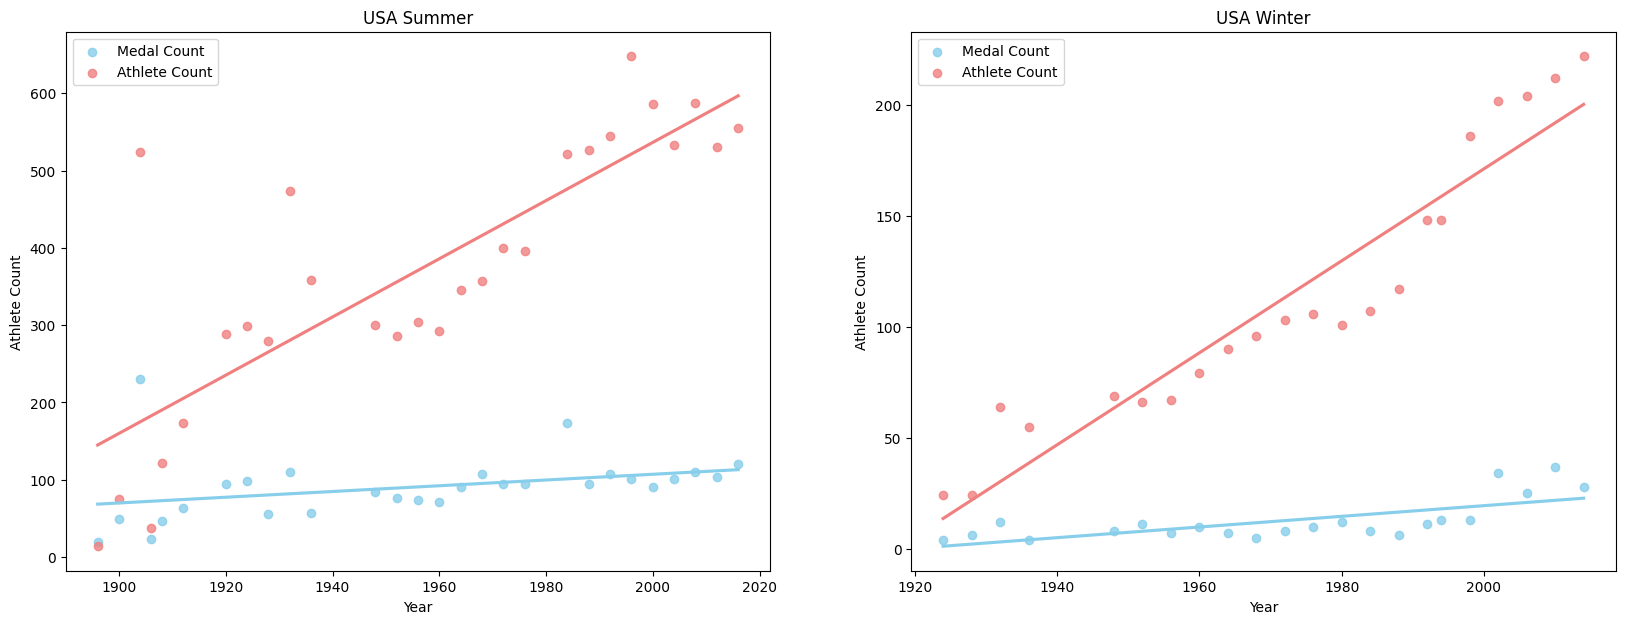

In [50]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('USA Summer')
sns.regplot(x=df_athletes_medal_count_summer_usa.index, y=df_athletes_medal_count_summer_usa['Medal Count'], color='skyblue', ci=None, label='Medal Count')
sns.regplot(x=df_athletes_medal_count_summer_usa.index, y=df_athletes_medal_count_summer_usa['Athlete Count'], color='lightcoral', ci=None, label='Athlete Count')
plt.legend()

plt.subplot(1,2,2)
plt.title('USA Winter')
sns.regplot(x=df_athletes_medal_count_winter_usa.index, y=df_athletes_medal_count_winter_usa['Medal Count'], color='skyblue', ci=None, label='Medal Count')
sns.regplot(x=df_athletes_medal_count_winter_usa.index, y=df_athletes_medal_count_winter_usa['Athlete Count'], color='lightcoral', ci=None, label='Athlete Count')
plt.legend()
plt.show()

**Rationale:** As before, we will plot USA values. We will use numpy's polyfit function to calculate the trendline. We will use a degree 1 polynomial, as we want a linear trendline. We will plot the trendline for both athletes and medals. Using seaborn will simplify plotting.

## Question 4 (5 points)

This third question focus on understanding the relations between elements.


### 4.a) Is there any relation between the medals won by different countries?

Study the relation in the evolution of medals won by different countries over the years.

Select four countries with a significative number of medals.

Note: Some useful
* Drop columns - [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)
* Rename columns - [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)


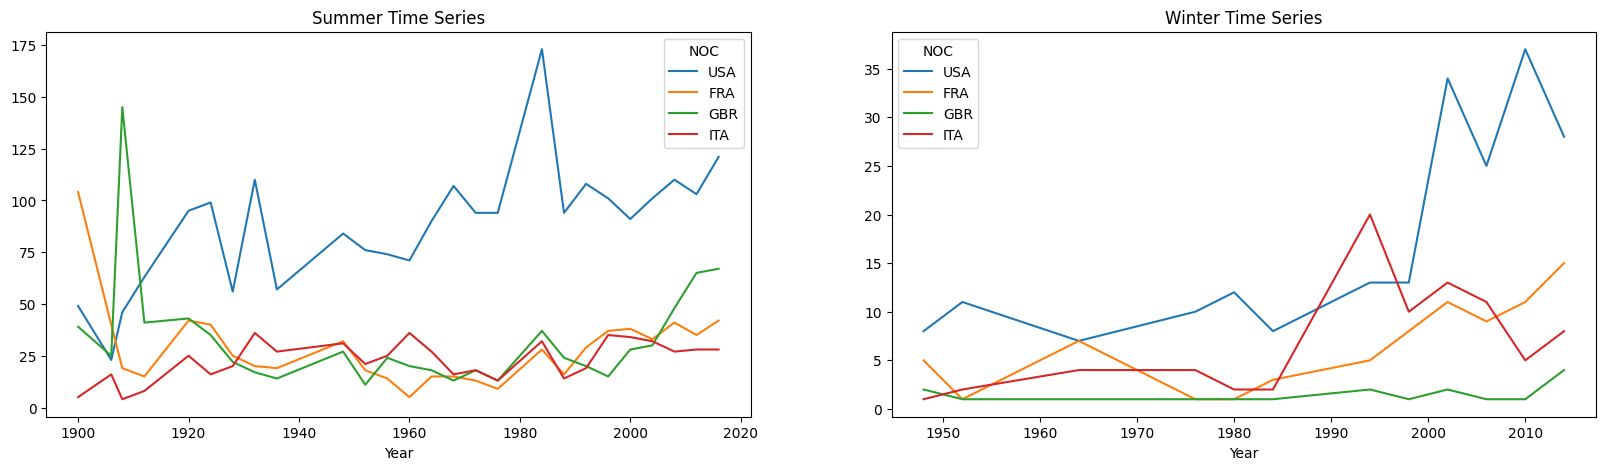

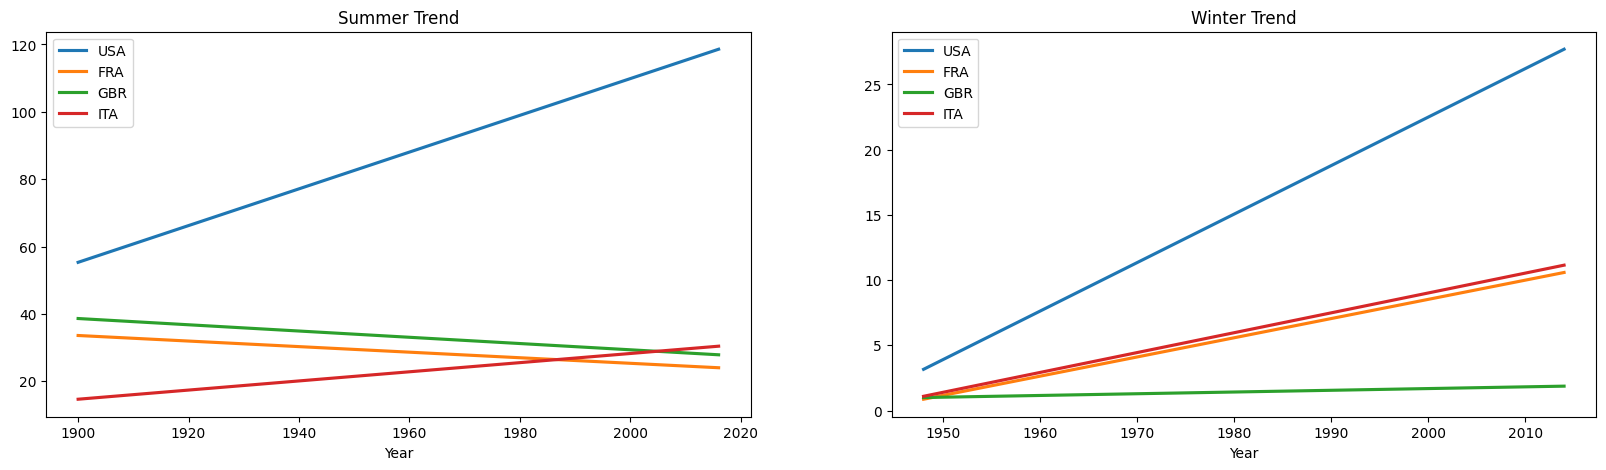

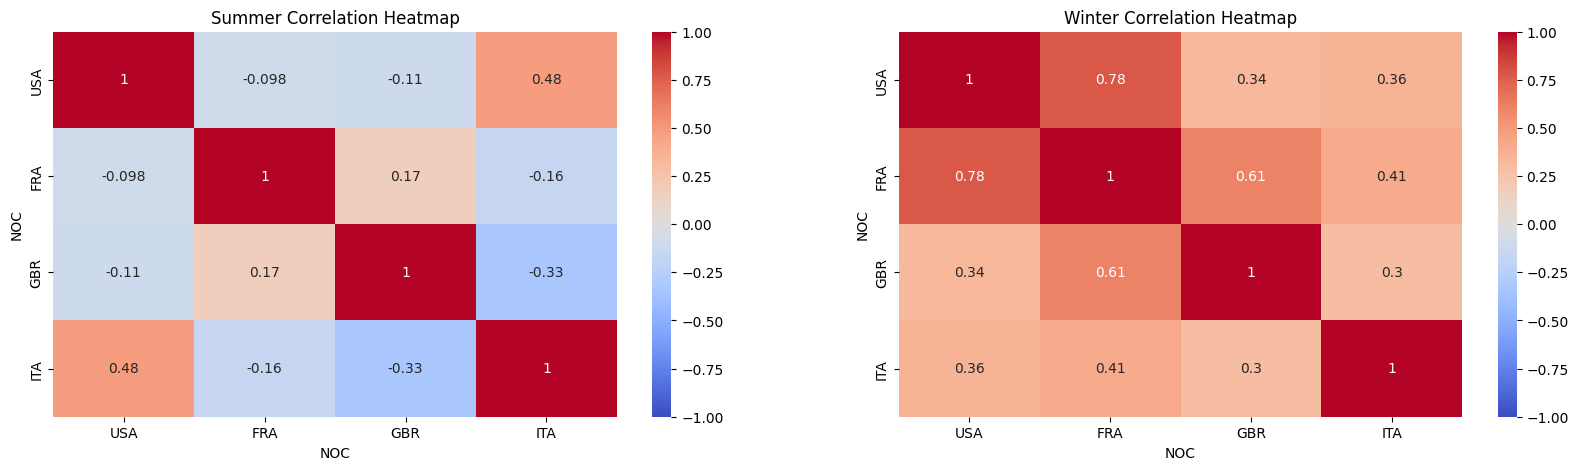

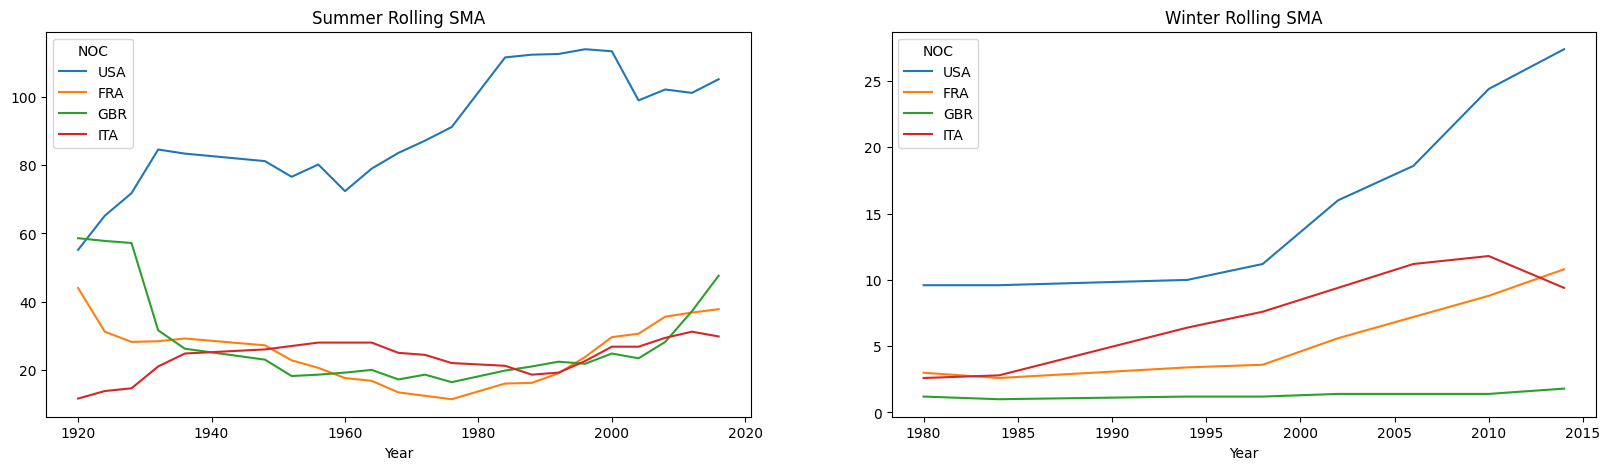

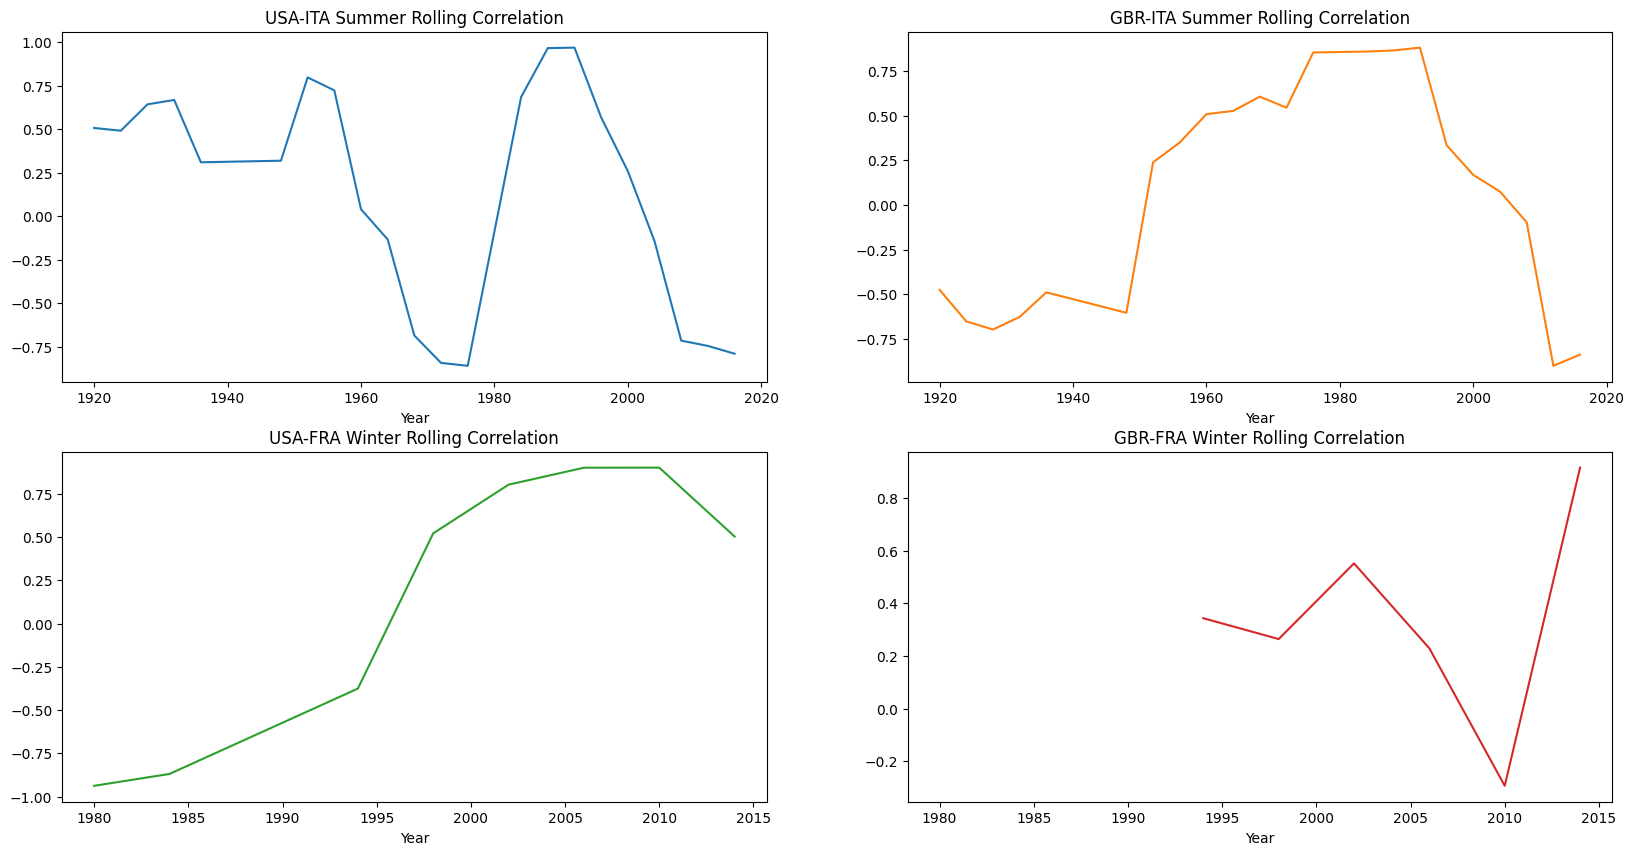

In [35]:
# Preparing Data
df_medal_relation = df_medal_count_country.loc[(__builtins__.slice(None), ['USA', 'FRA', 'GBR', 'ITA'], __builtins__.slice(None))].unstack(1)
df_medal_relation_summer = df_medal_relation.loc[(__builtins__.slice(None), 'Summer'),:].dropna().droplevel(1)  # only summer data
df_medal_relation_winter = df_medal_relation.loc[(__builtins__.slice(None), 'Winter'),:].dropna().droplevel(1)  # only winter data

# Time Series
plt.figure(figsize=(20,5))
df_medal_relation_summer.plot(ax=plt.subplot(1,2,1), title='Summer Time Series')
df_medal_relation_winter.plot(ax=plt.subplot(1,2,2), title='Winter Time Series')
plt.show()

# Trendlines
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Summer Trend')
for i in df_medal_relation_summer.columns:
    sns.regplot(x=df_medal_relation_summer.index, y=df_medal_relation_summer[i], scatter=False, ci=None)
plt.legend(labels=df_medal_relation_summer.columns, loc='upper left')
plt.gca().set_ylabel('')


plt.subplot(1,2,2)
plt.title('Winter Trend')
for i in df_medal_relation_winter.columns:
    sns.regplot(x=df_medal_relation_winter.index, y=df_medal_relation_winter[i], scatter=False, ci=None)
plt.legend(labels=df_medal_relation_winter.columns, loc='upper left')
plt.gca().set_ylabel('')
plt.show()

# Correlation Heatmap
df_corr_matrix_summer = df_medal_relation_summer.corr()
df_corr_matrix_winter = df_medal_relation_winter.corr()
plt.figure(figsize=(20,5))
sns.heatmap(df_corr_matrix_summer, annot = True, cmap='coolwarm', vmin=-1, vmax=1, ax=plt.subplot(1,2,1))
plt.title('Summer Correlation Heatmap')
sns.heatmap(df_corr_matrix_winter, annot = True, cmap='coolwarm', vmin=-1, vmax=1, ax=plt.subplot(1,2,2))
plt.title('Winter Correlation Heatmap')
plt.show()

# Rolling SMA (window = Every 5 editions ~ 20 years)

df_medal_relation_summer_sma = df_medal_relation_summer.rolling(5).mean()
df_medal_relation_winter_sma = df_medal_relation_winter.rolling(5).mean()
plt.figure(figsize=(20,5))
df_medal_relation_summer_sma.plot(ax=plt.subplot(1,2,1), title='Summer Rolling SMA')
df_medal_relation_winter_sma.plot(ax=plt.subplot(1,2,2), title='Winter Rolling SMA')
plt.show()

# Rolling Correlations (same window) for highest correlations: USA-ITA and GBR-ITA in the summer and USA-FRA and GBR-FRA in the winter

plt.figure(figsize=(20,10))
df_medal_relation_summer['USA'].rolling(5).corr(df_medal_relation_summer['ITA']).plot(title='USA-ITA Summer Rolling Correlation', ax=plt.subplot(2,2,1), color='#1f77b4')
df_medal_relation_summer['GBR'].rolling(5).corr(df_medal_relation_summer['ITA']).plot(title='GBR-ITA Summer Rolling Correlation', ax=plt.subplot(2,2,2), color='#ff7f0e')
df_medal_relation_winter['USA'].rolling(5).corr(df_medal_relation_winter['FRA']).plot(title='USA-FRA Winter Rolling Correlation', ax=plt.subplot(2,2,3), color='#2ca02c')
df_medal_relation_winter['GBR'].rolling(5).corr(df_medal_relation_winter['FRA']).plot(title='GBR-FRA Winter Rolling Correlation', ax=plt.subplot(2,2,4), color='#d62728')
plt.show()




**Present an interpretation of the results here:** The countries selected will be the USA, France, the UK and Italy, based on the number of medals and the completeness of data over time. To perform our analysis, we will plot time series and trendlines, as well as correlation heatmaps and rolling correlations and Simple Moving Averages. There will be plots for both summer and winter olympics, as it does not make sense to aggregate both seasons together in the analysis.

The best approach to anayze the time series is to follow the US line and, whenever there is a big variation, we try to see the effects in the other countries. We do this because the US has a much higher number of medals than other countries, so changes in the US would be more likely to show the hypothesized effect on other countries. However, after doing this we fail to observe any consistent pattern on the other countries on the summer time series, as they don't consistently change in response to the same change in the US. As for the winter time series, we can see a consistent increase in all countries, but since all countries have a low number of medals, this is not very relevant evidence (although against the effect studied).

 As for the trend, although the US has a great upward trend, we can observe both upward and downward trends in other countries in the summer olynpics. If the effect was true, the upward trend of the US would cause the other countries to have a downward trend, which is not the case. In the winter olympics, all countries show an upward trend. This would be evidence against the hypothesis that the number of medals won by different countries is related. This is further confirmed by the correlation heatmap, where we can see on the summer side mostly either moderately strong positive correlations or weak negative correlations between countries, and on the winter side only positive correlations. If the effect we are hypothesizing was true, we would expect to see more widespread and stronger negative correlations.

This all leads to reject the hypothesis, but the rolling analysis allows us to present some arguments in favor of the hypothesis. For example, the rolling SMA in the summer Olympics show that while the US has increasing momentum, all other countries have decreasing momentum, as observable between 1940 and 1990. The rolling SMA in winter olympics does show all countries with upward momentum, but since none of the countries in the analysis (including the US) win a lot of medals, this is mostly irrelevant.

As for the rolling correlations, for the correlations we plotted, it showed that the relationship is not consistent overtime and changes from positive to negative and vice-versa. So, we should be critical of the correlation heatmap, as it only presents a value over a long historic period. There is effectively periods of time where we can see strong negative correlations that could hint towards the effect we are studying. 

Weighting the arguments of both sides, we can conclude that there is some evidence in favor of the hypothesis, but the effect we are analyzing is not pronounced enough in the data for us to be confident in supporting the hypothesis. We should extend our analysis by including more countries and controling specific sports and events, but based on the data we have now, we should reject the hypothesis.

### 4.b) Extended analysis

As medals are competitive, one could expect that the fact that some countries starts winning more medals leads other countries to win less medals. But this would only be true if the total number of medals would have remained constant.

Suggest an alternative analysis and implement it.



**Analysis proposed:** Using the same group of countries as in question a), we will recompute the number of medals won per year, but we will only consider the same events that were present in the initial period. This way, we will be able to pinpoint the effect of countries winning more medals and consequently all the others winning less, without the effect of more medals being available over time.


**Rationale of implementation:** To implement this, we can keep the orignal way of counting medals. However, we need to drop any rows with events that are different than the events of the first period. We will set the events of the inaugural 1896 Olympics as the constant. We can then compute time series, trends and correlation heatmaps to assess the effect we are studing, as we did in question a).

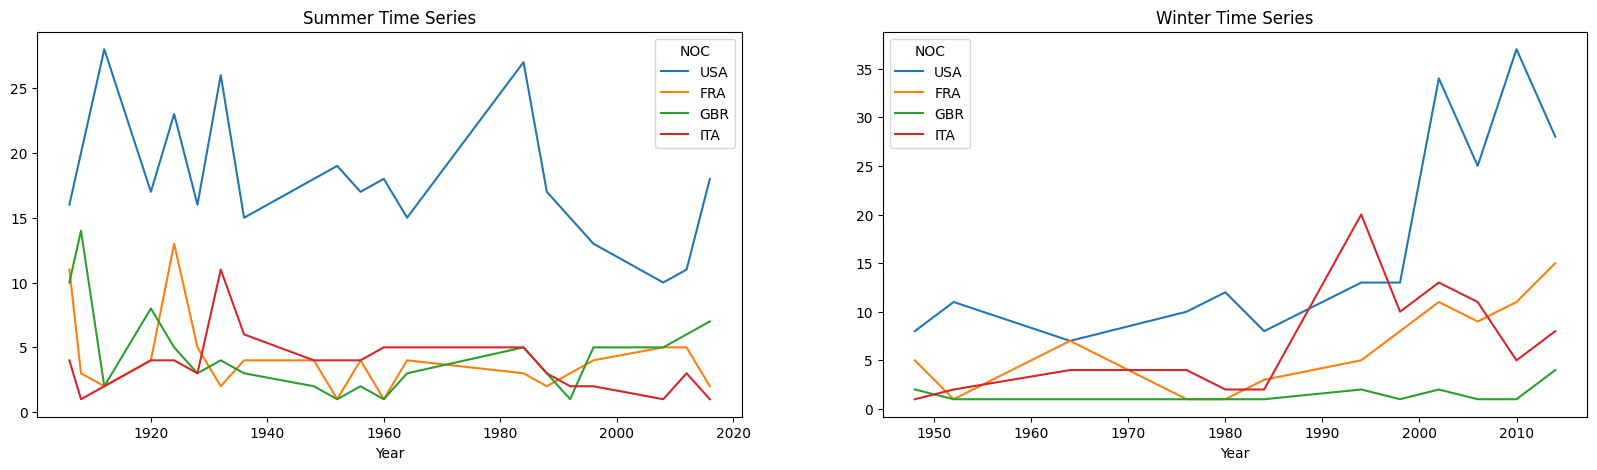

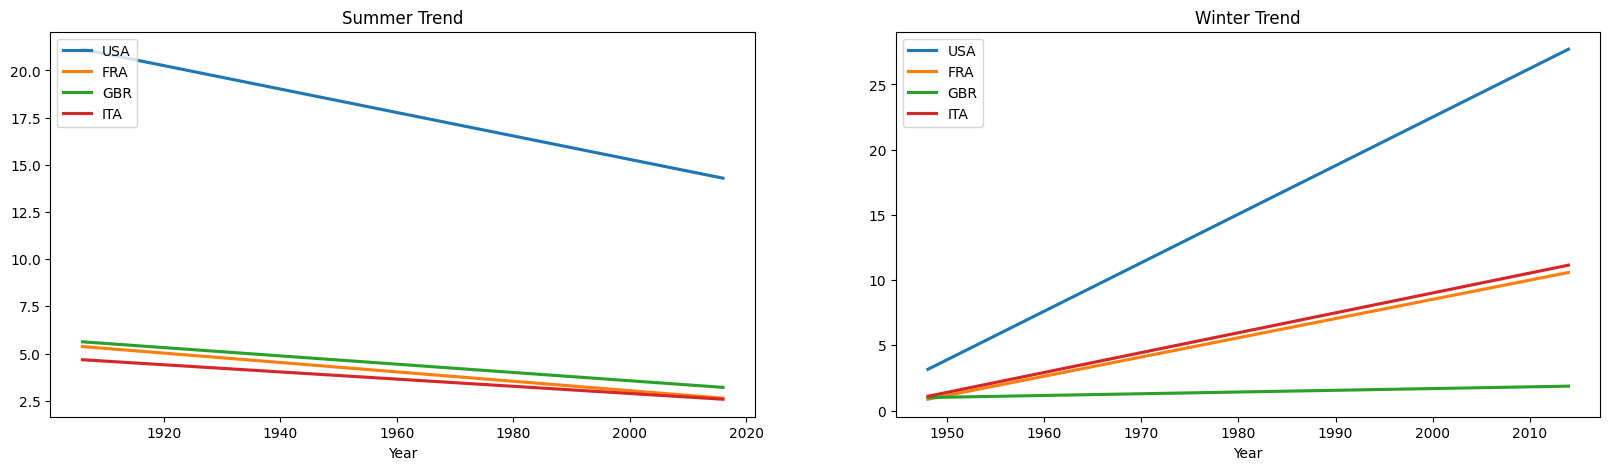

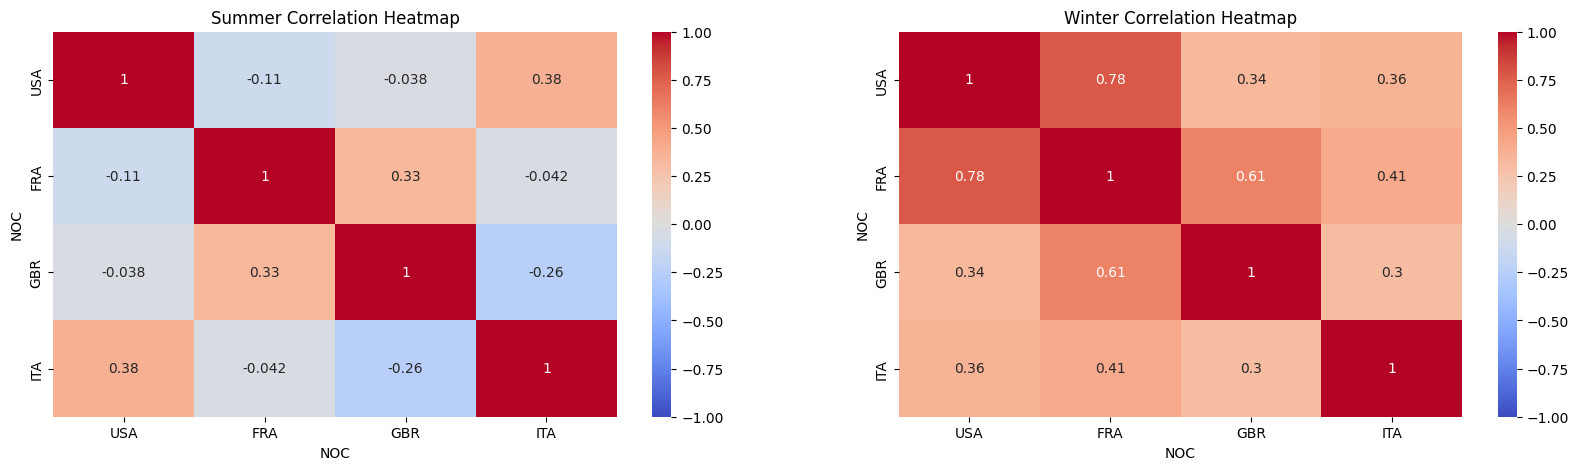

In [30]:
# Preparing Data
events_list_1896 = dataDF[dataDF['Year']==1896]['Event'].unique()       # get the events list from 1896 to filter the data

medals_count_fixedevents = dataDF[dataDF['Event'].isin(events_list_1896)].dropna(subset='Medal').drop_duplicates(subset=['Year', 'Team', 'Event', 'Medal'])
medals_count_fixedevents = medals_count_fixedevents.groupby(['Year', 'NOC', 'Season']).size().sort_index()

df_medal_relation_fixed = medals_count_fixedevents.loc[(__builtins__.slice(None), ['USA', 'FRA', 'GBR', 'ITA'], __builtins__.slice(None))].unstack(1)
df_medal_relation_summer_fixed = df_medal_relation_fixed.loc[(__builtins__.slice(None), 'Summer'),:].dropna().droplevel(1)  # only summer games
df_medal_relation_winter_fixed = df_medal_relation.loc[(__builtins__.slice(None), 'Winter'),:].dropna().droplevel(1)    # only winter games


# Time Series
plt.figure(figsize=(20,5))
df_medal_relation_summer_fixed.plot(ax=plt.subplot(1,2,1), title='Summer Time Series')
df_medal_relation_winter_fixed.plot(ax=plt.subplot(1,2,2), title='Winter Time Series')
plt.show()

# Trendlines
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Summer Trend')
for i in df_medal_relation_summer_fixed.columns:
    sns.regplot(x=df_medal_relation_summer_fixed.index, y=df_medal_relation_summer_fixed[i], scatter=False, ci=None)
plt.legend(labels=df_medal_relation_summer_fixed.columns, loc='upper left')
plt.gca().set_ylabel('')


plt.subplot(1,2,2)
plt.title('Winter Trend')
for i in df_medal_relation_winter_fixed.columns:
    sns.regplot(x=df_medal_relation_winter_fixed.index, y=df_medal_relation_winter_fixed[i], scatter=False, ci=None)
plt.legend(labels=df_medal_relation_winter_fixed.columns, loc='upper left')
plt.gca().set_ylabel('')
plt.show()

# Correlation Heatmap
df_corr_matrix_summer_fixed = df_medal_relation_summer_fixed.corr()
df_corr_matrix_winter_fixed = df_medal_relation_winter_fixed.corr()
plt.figure(figsize=(20,5))
sns.heatmap(df_corr_matrix_summer_fixed, annot = True, cmap='coolwarm', vmin=-1, vmax=1, ax=plt.subplot(1,2,1))
plt.title('Summer Correlation Heatmap')
sns.heatmap(df_corr_matrix_winter_fixed, annot = True, cmap='coolwarm', vmin=-1, vmax=1, ax=plt.subplot(1,2,2))
plt.title('Winter Correlation Heatmap')
plt.show()



**Rationale and comments:** From the time series, we can observe multipe periods where all countries were increasing in the number of medals won, while the effect we are looking for is much rarer. The trend plots further confirm this, as for both winter and summer olympics we can see that the trend is either positive or negative for allcountries. What we would expect, is for some countries to have a positive trend, causing the others to have a negative trend. 
Finally, the correlation heatmap shows widely positive correlations between the countries. Only the correlation between Great Britain and Italy is considerably negative, but this was also the case in the original data set with all the events, so we cannot attribute this to the effect we are studying. If the effect was pronounced, we would expect to see more negative correlations between the countries. 

Overall, all the analysis points to the fact that the effect we are studying is not very pronounced, and that the number of medals won by a country does not have a significant effect on the number of medals won by other countries, even if we control for a fixed number of events. Still, it would be advisable to include more countries in the analyis, in order to have a more complete picture.

## Question 5 (2 points)

This group focus on implementation using Spark SQL.

In [31]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Simple test") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
dfSpark = df = spark.read.option("header", True).option("inferSchema",True).csv(dataFileName)
dfSpark.show()


+---+--------------------+---+---+------+------+--------------+---+-----------+----+------+-----------+--------------------+--------------------+-----+
| ID|                Name|Sex|Age|Height|Weight|          Team|NOC|      Games|Year|Season|       City|               Sport|               Event|Medal|
+---+--------------------+---+---+------+------+--------------+---+-----------+----+------+-----------+--------------------+--------------------+-----+
|  1|           A Dijiang|  M| 24|   180|    80|         China|CHN|1992 Summer|1992|Summer|  Barcelona|          Basketball|Basketball Men's ...|   NA|
|  2|            A Lamusi|  M| 23|   170|    60|         China|CHN|2012 Summer|2012|Summer|     London|                Judo|Judo Men's Extra-...|   NA|
|  3| Gunnar Nielsen Aaby|  M| 24|    NA|    NA|       Denmark|DEN|1920 Summer|1920|Summer|  Antwerpen|            Football|Football Men's Fo...|   NA|
|  4|Edgar Lindenau Aabye|  M| 34|    NA|    NA|Denmark/Sweden|DEN|1900 Summer|1900|Summ

### 5.a) Reimplement question 1.e in Spark SQL.


In [32]:
dfSpark.createOrReplaceTempView('dfSpark')
df_metal_count_id_spark = spark.sql("""SELECT ID, Name, SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) as Gold,
                                    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) as Silver, SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) as Bronze
                                    FROM dfSpark 
                                    WHERE Medal != 'NA'
                                    GROUP BY ID, Name 
                                    ORDER BY Gold DESC, Silver DESC, Bronze DESC""")

df_metal_count_id_spark.show()

+------+--------------------+----+------+------+
|    ID|                Name|Gold|Silver|Bronze|
+------+--------------------+----+------+------+
| 94406|Michael Fred Phel...|  23|     3|     2|
| 33557|"Raymond Clarence...|  10|     0|     0|
| 67046|Larysa Semenivna ...|   9|     5|     4|
| 87390|Paavo Johannes Nurmi|   9|     3|     0|
|113912|   Mark Andrew Spitz|   9|     1|     1|
| 69210|"Frederick Carlto...|   9|     1|     0|
| 11951| Ole Einar Bjrndalen|   8|     4|     1|
| 35550|Birgit Fischer-Sc...|   8|     4|     0|
|119922|"Jennifer Elisabe...|   8|     3|     1|
| 57998|          Sawao Kato|   8|     3|     1|
| 11642|"Matthew Nicholas...|   8|     2|     1|
| 13029|  Usain St. Leo Bolt|   8|     0|     0|
|  4198|Nikolay Yefimovic...|   7|     5|     3|
|109161|Borys Anfiyanovyc...|   7|     4|     2|
| 18826|Vra slavsk (-Odlo...|   7|     4|     0|
| 21402|Viktor Ivanovych ...|   7|     3|     1|
| 39726|Aladr Gerevich (-...|   7|     1|     2|
|107383|"Donald Arth

### 5.b) Reimplement question 1.d in Spark SQL.


In [33]:
df_medal_count_year_spark = spark.sql("""WITH Ranked AS (SELECT Year, ID, Name, COUNT(Medal) as Number_of_Medals, ROW_NUMBER() OVER (PARTITION BY Year ORDER BY COUNT(Medal) DESC) as Rank
                                      FROM dfSpark
                                      WHERE Medal != 'NA' AND Season = 'Summer' AND Year > 1950
                                      GROUP BY Year, ID, Name)
                                      SELECT Year, ID, Name, Number_of_Medals
                                      FROM Ranked
                                      WHERE Rank = 1
                                      ORDER BY Year
                                      """)	
# Use the ROW_NUMBER() Function instead of ranks so that in case of ties, the first athlete in the data set is assigned 1 and the second 2; consistent with 1d) solution

df_medal_count_year_spark.show()

+----+------+--------------------+----------------+
|Year|    ID|                Name|Number_of_Medals|
+----+------+--------------------+----------------+
|1952| 50011|Mariya Kindrativn...|               7|
|1956| 58489|gnes Keleti-Srkny...|               6|
|1960|109161|Borys Anfiyanovyc...|               7|
|1964| 67046|Larysa Semenivna ...|               6|
|1968|127501|Mikhail Yakovlevi...|               7|
|1972|113912|   Mark Andrew Spitz|               7|
|1976|  4198|Nikolay Yefimovic...|               7|
|1980| 28790|Aleksandr Nikolay...|               8|
|1984| 69459|             Li Ning|               6|
|1988| 11642|"Matthew Nicholas...|               7|
|1992|109416|Vitaly Venediktov...|               6|
|1996| 85286|Aleksey Yuryevich...|               6|
|2000| 85286|Aleksey Yuryevich...|               6|
|2004| 94406|Michael Fred Phel...|               8|
|2008| 94406|Michael Fred Phel...|               8|
|2012| 94406|Michael Fred Phel...|               6|
|2016| 94406